# Machine Learning in Python - Project 2

Due Friday, April 15th by 5 pm UK local time.

Mou Jin s2103110

Yuan Wei s2114679

Siying Zhu s2252951

## 0. Setup

In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/project2')
!ls

Mounted at /content/drive
hotel.csv  proj2_2_3.ipynb  proj2.ipynb  proj2-Jin.ipynb


In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [3]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction

The hotel industry has evolved, with most reservations being booked through websites or phone calls. Customers have become accustomed to cancellation policies as a result. Indeed, if the booking is cancelled and the hotel cannot locate a replacement visitor to take the room, this service forces the hotel to pay for the reservation. As a result, cancellations have a financial impact on the hotel. Cancellations not only have immediate financial effects, but they also pose operational issues (such as over or understaffing). These issues may result in lower client satisfaction and bad feedback. Customers are increasingly checking online reviews before choosing a hotel, and those opinions may have a significant impact. We can clearly understand why avoiding bad reviews due to a room not being ready when the guest arrives can be valuable for a business. Therefore, the characteristics of the booking itself may be good indicators of whether or not a booking will be canceled. Engaging with the reasons why people are cancelling and what types of bookings are being canceled is crucial.

In order to solve this problem, we will use a real life hotel booking dataset to create a customer segmentation analysis in order to gain insights about the customers (and hopefully reasons why they cancel their reservation). We will then build a classification model to predict whether or not a booking will be canceled with the highest accuracy possible in order to manage their business accordingly, and increase their revenue. 

Our goal is to build a model that is able to classify a booking as canceled or non-canceled. In order to do so, we used data from a large hotel operator. The dataset provides data from real bookings scheduled to arrive between July, 2015 and August, 2017 from two hotels which are individual representative examples of their resort and city properties. Booking data from both hotels shares the same structure, with 29 variables describing the 119390 observations. For a detailed list and description of those variables please refer to the data overview in section 2.1. The dataset was then sorted into numeric and categorical categories making sure to address any null values, remove outliers, reformat certain features, and engineer new ones. 

Exploratory analysis includes analysis of the cancellation target variable and its relations with other features. Data visualisation tools were used to identify trends and valuable insights from those analysis. Four models were then presented: logistic regression,  SVC, decision tree and random forest. The model with the highest test accuracy was selected as our predictive model. Then the model refinement is required in order to gain a deeper understanding of factors influencing cancellations. The models were evaluated, and conclusions and recommendations were derived to optimize occupancy, improve operations, and increase a hotel's revenue.

## 2. Exploratory Data Analysis and Feature Engineering

### 2.1 Initial Look at the Data Structure

First, we need to overview the data to see how many features, observations, and missing values are contained in this dataset.

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

We can see the data has 30 attributes and 119390 instances. Notice that there are 4 attributes not fully observed, which are `children`, `country`, `agent`, and `company`. However, for `agent`, and `company`, the attributes weren't fully observed probably because those customers don't have such attributes rather than missing values. For the attribute `country`, we don't know if this contains those people who don't have an original country. Thus, we will convert the 'null' values to a category and only assume the attribute `children` contains missing values.

In [5]:
# convert 'null' to a category 'none'
cat_var = ['country', 'agent', 'company']

for i in cat_var:
  d[i] = np.where(d[i].isna(), 'none', d[i])

Because there are only 4 missing values in the dataset which contains 119390 observations, we can assume the missing values can be dropped without any significant effects.

In [6]:
# remove 'null' values in 'children'
d = d.dropna(subset=['children'])

### 2.2 Anomaly Detection
According to the definition of each attribute, there are actually 13 numerical variables besides the date-related variables, which are `lead_time`, `stays_in_weekend_nights`, `stays_in_week_nights`, `adults`, `children`, `babies`, `previous_cancellations`, `previous_bookings_not_canceled`, `booking_changes`, `days_in_waiting_list`, `adr`, `required_car_parking_spaces`, and `total_of_special_requests`.

Let's identify potential outliers using boxplots first.

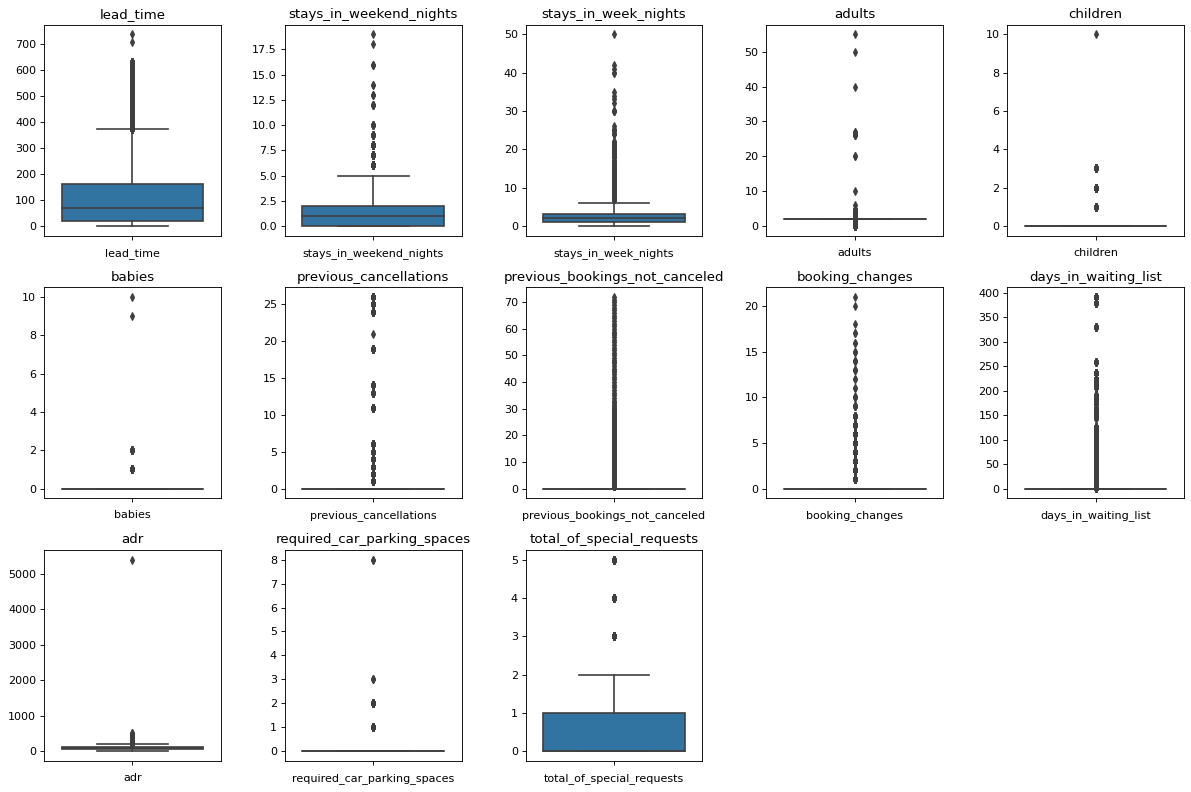

In [45]:
num_var = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
           'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 
           'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
  if i < 13:
   sns.boxplot(y = d[num_var[i]], ax = axes[i])
   axes[i].set_title(f'{num_var[i]}')
   axes[i].set_xlabel(num_var[i])
   axes[i].set_ylabel('')
  else:
    ax.remove()
plt.tight_layout()
plt.show()

From the boxplots, we can see all the potential outliers are from upper quantiles. However, we can not remove outliers by Tukey fences because this is a large dataset and the values of these numerical variables are too concentrated.

In [8]:
n = d.shape[0]
prop = pd.DataFrame(np.zeros(len(num_var)), columns = ['prop'], index = num_var)
for i in num_var:
  prop.T[i] = d[i].value_counts().max() / n
prop.sort_values(by = 'prop')

,prop
adr,0.031444
lead_time,0.053147
stays_in_week_nights,0.282127
stays_in_weekend_nights,0.435528
total_of_special_requests,0.588997
adults,0.751152
booking_changes,0.848592
children,0.928049
required_car_parking_spaces,0.937882
previous_cancellations,0.945689


The table above is the proportion of the value appearing most in each numerical variable and we can see that 8 of the 13 proportions are over 0.75. If we use Tukey fences, then all values except the value appearing most will be removed. What's more, the extremely unbalanced weight may lead the model bias. 

Thus, we decide to remove outliers only relying on `adr`, `lead_time`, and `stays_in_weekend_nights`. We can skip `stays_in_week_nights` because it is restricted by `stays_in_weekend_nights`.

In [9]:
outlr_var = ['adr', 'lead_time', 'stays_in_weekend_nights']

def find_boundaries(array1D, fold):
    upper_quant = pd.Series(array1D).quantile(0.75)
    lower_quant = pd.Series(array1D).quantile(0.25)
    IQR = upper_quant - lower_quant
    lower_boundary = lower_quant - (IQR * fold) 
    upper_boundary = upper_quant + (IQR * fold)
    
    return upper_boundary, lower_boundary
    
d_no_outlr = d.copy()

for i in outlr_var:
  upper_boundary_, lower_boundary_ = find_boundaries(d_no_outlr[i], 1.5)
  d_no_outlr[i] = np.where(d_no_outlr[i] > upper_boundary_, np.nan, d_no_outlr[i])
    

d_no_outlr = d_no_outlr.loc[d_no_outlr[outlr_var + ['children']].dropna(axis=0).index]

d_no_outlr.shape

(112329, 30)

There are 112329 observations left after removing outliers.

### 2.3 Feature Engineering

Our goal is to predict when a booking will be cancelled.

First, for the convenience of analysis, convert the variable `hotel` to binary form where `resort hotel` = 0 and `city hotel` = 1.

In [10]:
d_processed = d_no_outlr.copy()
d_processed['hotel'] = (d_processed['hotel'] == 'City Hotel').astype(int)

Second, we will deal with the numerical variables.

For the attributes `previous_bookings_not_canceled` and `previous_cancellations`, we can compute the previous cancellation rates for each observation and this may can help us to predict cancellations.

In [11]:
prev_booking = d_processed['previous_bookings_not_canceled'] + d_processed['previous_cancellations']

d_processed['previous_cancellation_rates'] = np.where(prev_booking == 0, 0, 
                                                      d_processed['previous_cancellations']/prev_booking)

What's more, we can combine the two features `stays_in_weekend_nights` and `stays_in_week_nights` by creating a new feature `stay_days` to see if the cancellations are related to the total reservation days.

In [12]:
d_processed['stay_days'] = d_processed['stays_in_weekend_nights'] + d_processed['stays_in_week_nights']

Third, for the categorical variables, add a binary variable `same_room_type` where `same_room_type` = 1 if the reserved and assigned room types are same, and `same_room_type` = 0 otherwise.

In [13]:
d_processed['same_room_type'] = (d_processed['reserved_room_type'] == d_processed['assigned_room_type']).astype(int)

### 2.4 Exploratory Data Analysis

#### 2.4.1 Correlations

Examine if there are any numerical or binary variables correlated with each other.

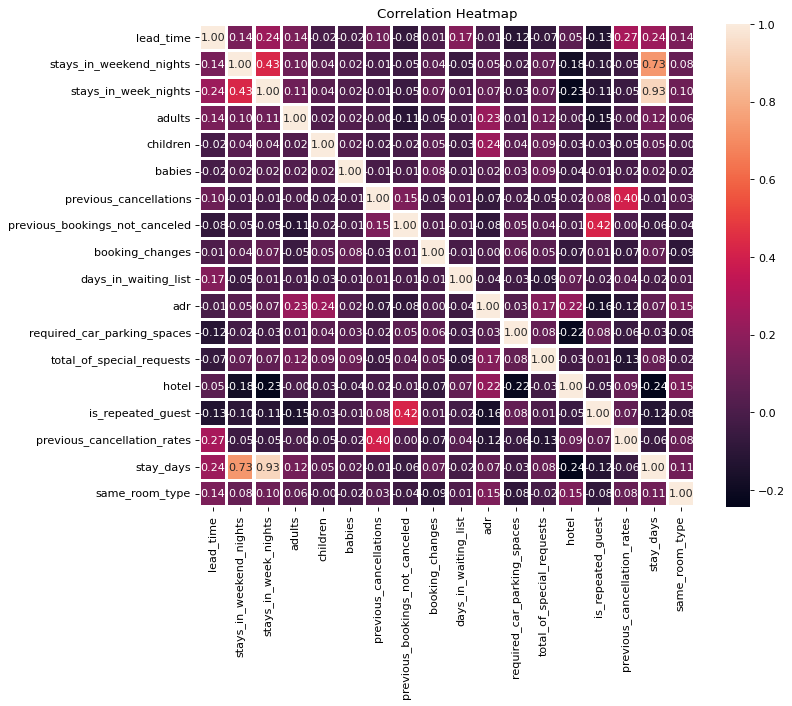

In [14]:
# Create a heatmap to check the correlation between imdb_rating and other parameters
add_var = ['hotel', 'is_repeated_guest', 'previous_cancellation_rates', 'stay_days', 'same_room_type']
num_bin_var = num_var + add_var
plt.subplots(figsize = (10,8))
sns.heatmap(d_processed[num_bin_var].corr(), annot=True, fmt='.2f', linewidths=2)
plt.title("Correlation Heatmap")
plt.show()


From the correlations we get, most of features do not have a high correlation.

Next, examine if there any features correlated with output variable.

In [15]:
from scipy import stats

for i, feature in enumerate(num_bin_var):
  corr = pd.DataFrame(stats.pearsonr(d_processed[feature], d_processed['is_canceled']), 
                      index = ["cor", "p-value"],
                      columns = [feature])
  if i ==0:
    all_corr = corr
  else:
    all_corr = pd.concat([all_corr, corr], axis = 1)
        
display(all_corr.round(3).sort_values(by="cor", axis=1).T)

,cor,p-value
total_of_special_requests,-0.222,0.000
required_car_parking_spaces,-0.190,0.000
booking_changes,-0.140,0.000
is_repeated_guest,-0.084,0.000
previous_bookings_not_canceled,-0.057,0.000
babies,-0.030,0.000
stays_in_weekend_nights,-0.000,0.942
children,0.003,0.291
stay_days,0.018,0.000
stays_in_week_nights,0.024,0.000


From the correlations above, we can see there are only several features whose absolute value of the correlations are above 0.1. These features are `total_of_special_requests`, `required_car_parking_spaces`, `booking_changes`, `previous_cancellations`, `hotel`, `same_room_type`, `lead_time`, and `previous_cancellation_rates`.

Because `previous_cancellation_rates` comes from `previous_cancellations` and they are highly correlated, we will only use the variable `previous_cancellation_rates`.

#### 2.4.2 Date-Related Variables

Now, we are going to discuss the date-related variables we haven't been mentioned yet. The following graphs illustrate the proportion of bookings cancelled for each year, month, week, and date.

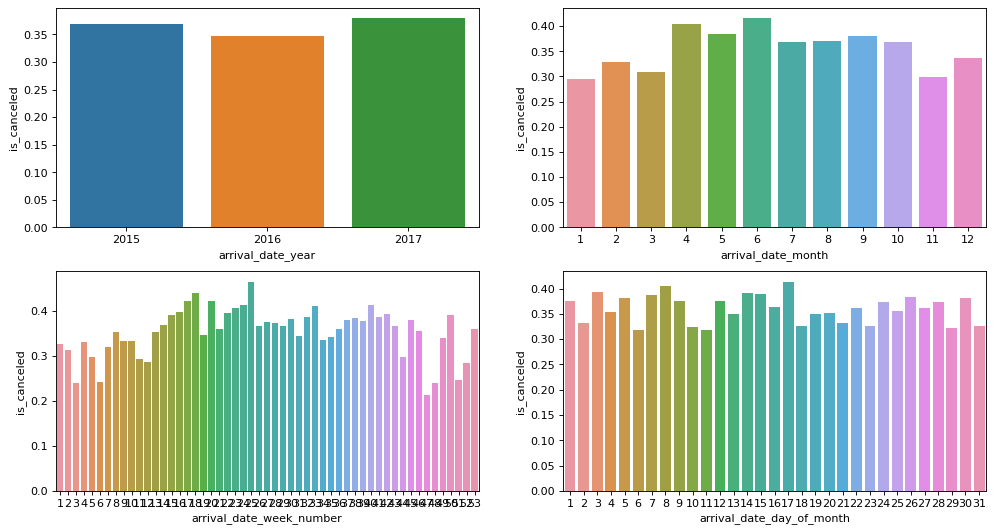

In [16]:
time_relate_var = ['arrival_date_year', 'arrival_date_month',
                   'arrival_date_week_number', 'arrival_date_day_of_month']

month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
         'September', 'October', 'November', 'December']
d_trans_month = d_processed.copy()

for i, mon in enumerate(month):
  d_trans_month['arrival_date_month'] = np.where(d_trans_month['arrival_date_month'] == mon, i+1, d_trans_month['arrival_date_month'])

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
  a = d_trans_month.groupby(time_relate_var[i])['is_canceled'].mean().to_frame()
  sns.barplot(x=a.index, y=a['is_canceled'], ax=axes[i])
plt.show()

According to the graphs, it seems like the rate of cancellation is little bit lower for winter, but in general, there are not any significant patterns in these graphs.

#### 2.4.3 Categorical Variables

For the remaining categorical variables we haven't mentioned yet, we will calculate the cancellation rate of each category in these variables. These categorical variables are `meal`, `market_segment`, `distribution_channel`, `deposit_type`, `customer_type`, `country`, `agent`, and `company`.

In [17]:
# Proportion of booking cancelled for each meal type
d_trans_month.groupby('meal')['is_canceled'].mean().sort_values(ascending=False)

meal
FB           0.640669
SC           0.371620
BB           0.360950
HB           0.350558
Undefined    0.248408
Name: is_canceled, dtype: float64

In [18]:
# Proportion of booking cancelled for each market segment
d_trans_month.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False)

market_segment
Groups           0.590200
Online TA        0.361880
Offline TA/TO    0.342155
Aviation         0.219409
Corporate        0.187228
Direct           0.149042
Complementary    0.130904
Name: is_canceled, dtype: float64

In [19]:
# Proportion of booking cancelled for each distribution channel
d_trans_month.groupby('distribution_channel')['is_canceled'].mean().sort_values(ascending=False)

distribution_channel
TA/TO        0.400139
Corporate    0.220921
GDS          0.178947
Direct       0.171694
Undefined    0.000000
Name: is_canceled, dtype: float64

In [20]:
# Proportion of booking cancelled for each deposit type
d_trans_month.groupby('deposit_type')['is_canceled'].mean().sort_values(ascending=False)

deposit_type
Non Refund    0.992804
No Deposit    0.280527
Refundable    0.210191
Name: is_canceled, dtype: float64

In [21]:
# Proportion of booking cancelled for each customer type
d_trans_month.groupby('customer_type')['is_canceled'].mean().sort_values(ascending=False)

customer_type
Transient          0.394913
Contract           0.302824
Transient-Party    0.258383
Group              0.095915
Name: is_canceled, dtype: float64

In [22]:
# Proportion of booking cancelled for each country
d_trans_month.groupby('country')['is_canceled'].mean()

country
ABW     0.000000
AGO     0.508143
ALB     0.166667
AND     1.000000
ARE     0.840909
          ...   
VNM     0.250000
ZAF     0.394737
ZMB     0.500000
ZWE     0.500000
none    0.140167
Name: is_canceled, Length: 176, dtype: float64

In [23]:
# Proportion of booking cancelled for each agent
d_trans_month.groupby('agent')['is_canceled'].mean()

agent
1.0      0.679878
10.0     0.246154
103.0    0.095238
104.0    0.096154
105.0    0.307692
           ...   
95.0     0.140741
96.0     0.468085
98.0     0.491935
99.0     0.382353
none     0.244857
Name: is_canceled, Length: 330, dtype: float64

In [24]:
# Proportion of booking cancelled for each company
d_trans_month.groupby('company')['is_canceled'].mean()

company
10.0     0.000000
100.0    0.000000
101.0    0.000000
102.0    1.000000
103.0    0.000000
           ...   
93.0     0.500000
94.0     0.160920
96.0     0.000000
99.0     0.083333
none     0.373432
Name: is_canceled, Length: 349, dtype: float64

From the proportions calculated above, we can see the cancellation rates are quite different among different categories. Thus, these categorical variables may have effects on predicting cancellation.

In [25]:
data = d_trans_month.copy().reset_index()

## 3. Model Fitting and Tuning

Since the projecting when a booking will be cancelled is a classification problem, we explore some classfying models, such as logistic regression, decision trees, random forest and SVC.

Finally, we decide the decision tree classifier as our predictive model for following reasons:
- SVC are operated too slowly since there are more observations than features, so it is not very efficient. Besides, its predicting accury rate is not the best one.
- Compared with logistic regression, decision trees has higher accuracy and precision rates, which will help hotels make more gains from cancellation management.
- Based on the excellent performance of the decision tree, we thought that random forests might be better than the decision tree, so we also tried random forests, but the results showed that random forests were also very slow. Meanwhile, the accuracy was very similar to the decision tree.

Given the data analysis in part 2, we select the following variables to build our model:
- For numeric variables: we choose `total_of_special_requests`, `required_car_parking_spaces`, `booking_changes`, `hotel`, `lead_time` and `previous_cancellations_rates`, since their absolute correlation coefficient with dependent dummy variable `is_canceled` is above 0.1, which means thes variables may have stronger power to predict whether a cancellation will happen.
- For category variables: we choose `same_room_type`, `hotel`, `country`, `agent`, `company`, `meal`, `market_segment`, `deposit_type` and `customer_type`. `same_room_type` and `hotel` are already dummy variables, so now we need to convert string variables `country`, `agent`, `company`, `meal`, `market_segment`, `deposit_type` and `customer_type` into dummy variables in our model.Since all of `country`, `agent` and `company` have too many labels, we need to do some transformations.

Category variables transformation:
*********************************
|variable|transformation|
|---|---|
|country|we calculate the cancellation rate for each country and build a binary variable country_dum, which is 1 if the cancellation of the observed country is grearter that the corresponding median value, 0 otherwise|
|agent|we calculate the cancellation rate for each agent and build a binary variable agent_dum, which is 1 if the cancellation of the observed country is grearter that the corresponding median value, 0 otherwise|
|company|we calculate the cancellation rate for each company and build a binary variable company_dum, which is 1 if the cancellation of the observed country is grearter that the corresponding median value, 0 otherwise|
|meal|Convert to 5 dummy variables according to its kinds of labels|
|market_segment|Convert to 2 dummy variables according to its kinds of labels|
|deposit_type|Convert to 3 dummy variables according to its kinds of labels|
|customer_type|Convert to 4 dummy variables according to its kinds of labels|
|distribution_channel|Convert to 2 dummy variables according to its kinds of labels|


Below are functions from MLP workshop7, which will help in our later modelling

In [26]:
# this creates the matplotlib graph to make the confmat look nicer
# IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !
import warnings # prevent warnings
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()
  
# For ROC curve plotting function

def roc_plot(threshold=0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()

    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')

    plt.title("threshold = %.2f" % threshold)
    plt.show()


### 3.1 Baseline Decision Tree

Before fitting the model, we need to process our data. Using transformers in the sklearn package, we standardize our numeric variables, convert the classifying variables into dummy variables as described above, and then create a pipeline for the decision tree.

In [27]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# creat list that cancellation rate >= its median value for agent, country and company
for v in ['country', 'agent', 'company']:
    # if the cancellation rate for each of ['country', 'agent', 'company'] is larger than ite median
    # then we let the dummy variable to be 1
    a = pd.DataFrame(data.groupby(v)['is_canceled'].mean() >= 
                 data.groupby(v)['is_canceled'].mean().median()).reset_index()
    # change the name and convert boolean value to binary value
    a = a.rename(columns={'is_canceled': v + '_dum'})
    a[v +'_dum'] = a[v +'_dum'] + 0
    # merge and drop
    data = data.merge(a, on=v, how='left')
    data = data.drop(columns=[v])
    

def data_process(X):
    '''
    Extract independent variables from the data and deal with them
    '''

#     X = X.reset_index()
    # extract numeric, catagory and dependent variables respectively
    X_num = X[['total_of_special_requests', 'required_car_parking_spaces', 'booking_changes', 
                      'lead_time', 'previous_cancellation_rates']]
    ## here we put numeric variable 'same_room_type' and 'hotel' into the catagory set
    X_cat = X.drop(columns=['total_of_special_requests', 'required_car_parking_spaces', 'booking_changes', 
                      'lead_time', 'previous_cancellation_rates'])
    
    # standardize numerical data
    scaler = StandardScaler()
    X_num = scaler.fit_transform(X_num)
    X_num = pd.DataFrame(data=X_num, columns=['total_of_special_requests', 'required_car_parking_spaces', 
                                              'booking_changes',  'lead_time', 
                                              'previous_cancellation_rates'])
    # convert classifying variables
    X_cat = pd.get_dummies(X_cat)
    
    # combine X_num can X_cat
    X = pd.concat([X_num, X_cat], axis=1)
    
    return X


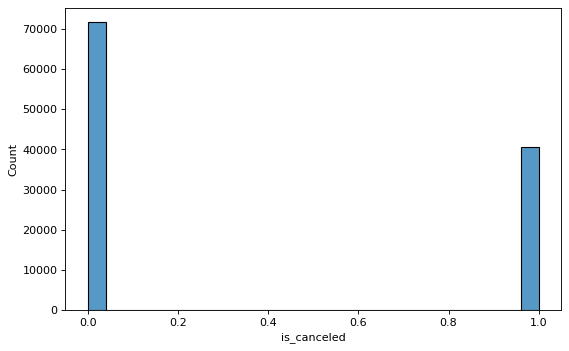

In [28]:
sns.histplot(data['is_canceled'])

From the histogram plot above, we get that the data is imbalanced for the dependent variable, so we should consider this issue when splitting the train and test datasets. Data should be stratified in terms of the `is_canceled` label to avoid biases.

In [29]:
from sklearn.model_selection import train_test_split
X = data[['total_of_special_requests', 'required_car_parking_spaces', 'booking_changes', 
          'same_room_type', 'lead_time', 'previous_cancellation_rates', 'hotel', 
          'country_dum', 'agent_dum', 'company_dum','meal', 
          'market_segment','deposit_type', 'customer_type', 'distribution_channel']]
y = data['is_canceled']
X = data_process(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                                    shuffle=True, stratify=y, random_state=42)


After data is ready, we can fit our model by decision tree classifier method, using selected feastures, `total_of_special_requests`, `required_car_parking_spaces`, `booking_changes`, `hotel`, `lead_time`, `previous_cancellations_rates`, `same_room_type`, `hotel`, `country`, `agent`, `company`, `meal`, `market_segment`, `deposit_type` and `customer_type`, to predict dependent variable `is_canceled`

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import plot_tree


# creat a pipeline for decision tree regression
DTC_1 = DecisionTreeClassifier(random_state=42)

# fit the model
DTC_1.fit(X_train, y_train)
print('done')

done


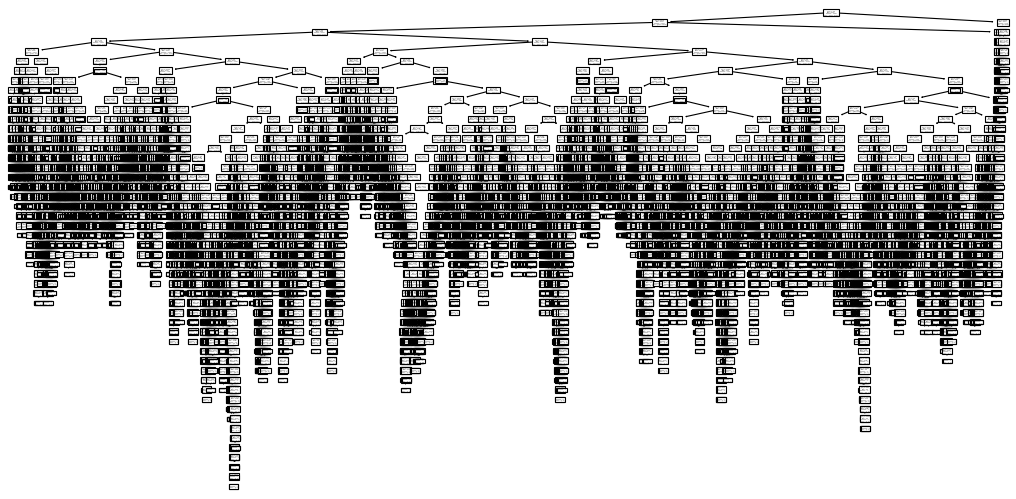

In [31]:
plt.figure(figsize=(16,8))
plot_tree(DTC_1)
plt.show()

As we can see above, the decision tree is too complex, and the complexity is likely to cause overfitting so we will prune these leaf notes later in the improvement part.

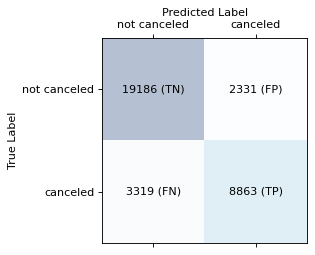

FPR: 0.1083
precision: 0.7918
NPV: 0.8525
recall: 0.7275
F 1: 0.7583
accuracy: 0.8323
Cross-val-score: 0.8111222332646278


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# predict
y_test_pred = DTC_1.predict(X_test)
# drow confusion matrix
confmat = confusion_matrix(y_true = y_test, y_pred=y_test_pred)
pretty_confusion_matrix(confmat, ['not canceled', 'canceled'], "",  labeling=True)

# out put results
print(f"FPR: {round(confmat[0,1]/(confmat[0,1]+confmat[0,0]),4)}")
print(f"precision: {round(precision_score(y_test, y_test_pred),4)}")
print(f"NPV: {round(confmat[0,0] / (confmat[0,0] + confmat[1,0]),4)}")
print(f"recall: {round(recall_score(y_test, y_test_pred),4)}")
print(f"F 1: {round(f1_score(y_test, y_test_pred),4)}")
print(f"accuracy: {round(accuracy_score(y_test, y_test_pred),4)}")
print(f'Cross-val-score: {cross_val_score(DTC_1, X_test, y_test, scoring="accuracy", cv=StratifiedKFold(shuffle=True)).mean()}')

Fit model using train set and test model by test set. In order to see the predictive result more directly, we draw the following confusion matrix. We can obtain some information from it. Our model successfully identifies 19186 true not cancelled cases and 8863 cancelled cases. However, the model wrong classified 2331 not cancelled cases and 3319 cancelled cases.

Furthermore, we calculate the following metrics to evaluate our model: FPR (false positive rate), precision, NPV(negative predictive value), recall, F1 score, and accuracy. Here, we are most interested in accuracy since there would be a damaging effect on hotels' reputation and income if they identified a cancellation or a non-cancellation that does not occur.


- $FPR = \frac{FP}{FP+TN} \approx 0.1083$

- $Recall = \frac{TP}{FN+TP} \approx 0.7275$

- $Precision = \frac{TP}{FP+TP} \approx 0.7918$

- $NPV = \frac{TN}{FN+TN} \approx 0.8525$

- $F1 = \frac {2 \times Precision \times Recall}{Precision + Recall} \approx 0.7583$

- $Accuracy = \frac {correctly classified}{total number} \approx 0.8323$

- Our model has an FPR of 0.1083, which means that it wrongly identifies 10.83% of all non-cancellation as a cancellation.
- Our model has a recall of 0.7275, which means it correctly identifies 72.75% of all cancellations.
- Our model has a precision of 0.7918, which means when it predicts a booking will be cancelled, it is correct 79.18% of the time.
- Our model has an NPV of 0.8525, which means when it predicts a booking will not be cancelled, it is correct 85.25% of the time.
- Our model has an F1 of 0.7583. It is a harmonic means of recall and precision.
- Our model has an accuracy of 0.8323, which means 83.23% of our sample is truly classified. By the way, we evaluate the accuracy by cross-validation, and the result indicates that our testing set is a valid representation of the data.

AUC value: 0.8096


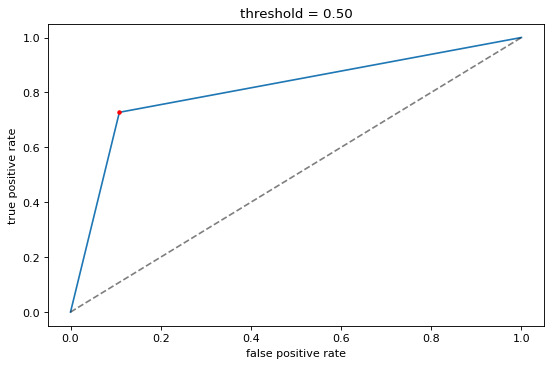

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

roc_calc = roc_curve(y_true = y_test, y_score = y_test_pred)
roc_calc
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

#Print the related AUC value 
print(f'AUC value: {round(roc_auc_score(y_true = y_test, y_score = y_test_pred), 4)}')

# plot ROC curve threshold 0.5
roc_plot()

Now we draw a ROC plot and calculate the AUC to be 0.8096, which means our model has a good ability to distinguish cancelled cases from non-cancelled ones.

### 3.2 Model Refinement

The decision tree model is notorious for being overfitted to the training dataset. There are so many branches and leaves, as we can see above. Thus, we prune the tree with a cost complexity pruning method to deal with it.

Pruning is a data compression technique and search algorithm that reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances. It helps to reduce the complexity of the classifier and hence improves predictive accuracy by the reduction of overfitting. Cost complexity pruning is one of the most used pruning methods.

We prune the tree by changing the value of ccp_alpha in DecisionTreeClassifier and then operate RandomizedSearchCV to find the fact that when the best hyperparameter alpha is 0.000045, and the original data should keep imbalanced, we get the best accuracy. Therefore, we can add this parameter to our baseline tree.

In [34]:
DTC = DecisionTreeClassifier(random_state=42)

# detemine values for hyper parameter alpha
path = DTC.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas

array([ 0.00000000e+00, -5.42101086e-20, -1.35525272e-20, ...,
        1.70309821e-02,  1.93093729e-02,  1.01843131e-01])

In [35]:
from sklearn.model_selection import RandomizedSearchCV
# creat a new pipeline for decision tree regression
DTC_2 = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001)

DTC_param_dist = {
    'ccp_alpha':ccp_alphas,
    'class_weight': [None, "balanced"],
}

DTC_rs = RandomizedSearchCV(DTC_2, 
                            param_distributions = DTC_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)


DTC_rs.fit(X_train, y_train)
print("done")

done


In [36]:
#Summarize the best 6 models with respect to mean_test_precision

DTC_rs_df = pd.DataFrame(DTC_rs.cv_results_)
DTC_rs_df.sort_values("mean_test_accuracy", ascending=False)[["param_class_weight",
                                                            "param_ccp_alpha", 
                                                           "mean_test_accuracy",
                                                            "mean_test_precision",
                                                           "mean_test_recall", 
                                                            "mean_test_f1"
                                                             ]].head()

,param_class_weight,param_ccp_alpha,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
50,None,0.000045,0.839527,0.817243,0.716612,0.763451
22,None,0.000025,0.838166,0.807681,0.724986,0.764088
41,None,0.000019,0.837047,0.800288,0.731987,0.764590
39,None,0.00002,0.837021,0.800738,0.731213,0.764372
21,None,0.000018,0.835940,0.797141,0.732796,0.763571


In [37]:
# creat a pipeline for decision tree regression
DTC_3 = DecisionTreeClassifier(random_state=42, ccp_alpha=0.000045)

# fit the model
DTC_3.fit(X_train, y_train)
print('done')

done


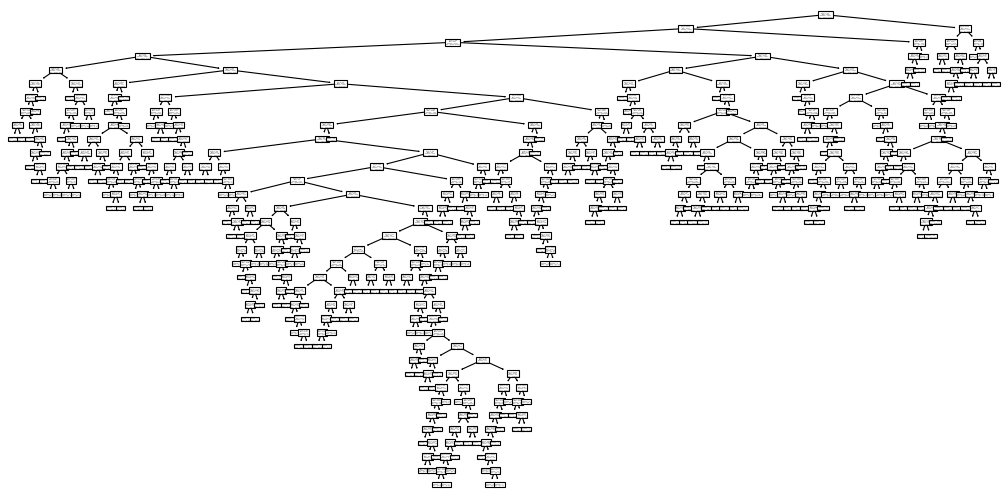

In [38]:
plt.figure(figsize=(16,8))
plot_tree(DTC_3)
plt.show()

Although there are a lot of leaf notes after pruning, it is clearly simpler than the original tree, and hence our cost complexity pruning method performs well. Now let's check its ability to predict using testing data.

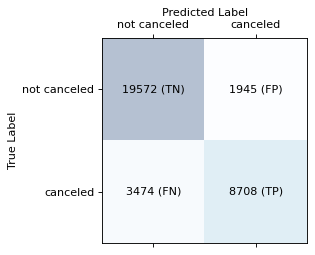

FPR: 0.0904
precision: 0.8174
NPV: 0.8493
recall: 0.7148
F 1: 0.7627
accuracy: 0.8392
Cross-val-score: 0.8283627874945566


In [39]:
y_test_pred = DTC_3.predict(X_test)

confmat = confusion_matrix(y_true = y_test, y_pred=y_test_pred)
pretty_confusion_matrix(confmat, ['not canceled', 'canceled'], "",  labeling=True)

print(f"FPR: {round(confmat[0,1]/(confmat[0,1]+confmat[0,0]),4)}")
print(f"precision: {round(precision_score(y_test, y_test_pred),4)}")
print(f"NPV: {round(confmat[0,0] / (confmat[0,0] + confmat[1,0]),4)}")
print(f"recall: {round(recall_score(y_test, y_test_pred),4)}")
print(f"F 1: {round(f1_score(y_test, y_test_pred),4)}")
print(f"accuracy: {round(accuracy_score(y_test, y_test_pred),4)}")
print(f'Cross-val-score: {cross_val_score(DTC_3, X_test, y_test, scoring="accuracy", cv=StratifiedKFold(shuffle=True)).mean()}')

We draw the above confusion matrix. Our model successfully identifies 19572 true not cancelled cases and 8708 cancelled cases. However, the model wrong classified 1945 non-cancelled cases and 3474 cancelled cases.

- Our model has an FPR of 0.0904, which means that it wrongly identifies 9.04% of all non-cancellation as a cancellation.
- Our model has a recall of 0.7148, which means it correctly identifies 71.48% of all cancellations.
- Our model has a precision of 0.8174, which means when it predicts a booking will be cancelled, it is correct 81.74% of the time.
- Our model has an NPV of 0.8493, which means when it predicts a booking will not be cancelled, it is correct 84.93% of the time.
- Our model has an F1 of 0.7627. It is a harmonic means of recall and precision.
- Our model has an accuracy of 0.8392, which means 83.92% of our sample is truly classified. By the way, we evaluate the accuracy by cross-validation, and the result indicates that our testing set is a valid representation of the data.

AUC value: 0.8122


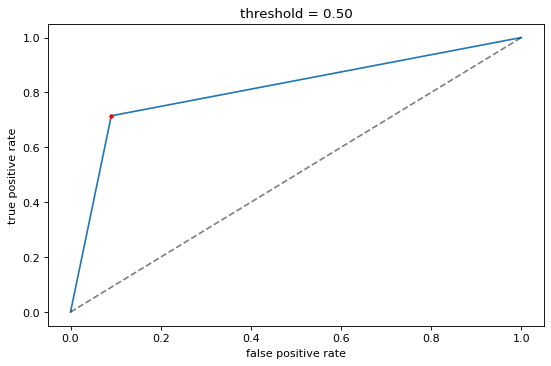

In [40]:
roc_calc = roc_curve(y_true = y_test, y_score = y_test_pred)
roc_calc
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

#Print the related AUC value 
print(f'AUC value: {round(roc_auc_score(y_true = y_test, y_score = y_test_pred), 4)}')

# plot ROC curve threshold 0.5
roc_plot()

From the ROC plot, we can conclude that our model looks good, with AUC of 0.8122.

After pruning, we can see that accuracy, precision, NPV, F1 and FPR improve a bit but with a slight reduction of recall. However, hotels pay most of their attention to accuracy and precision. Therefore, it is reasonable to accept the improved tree.

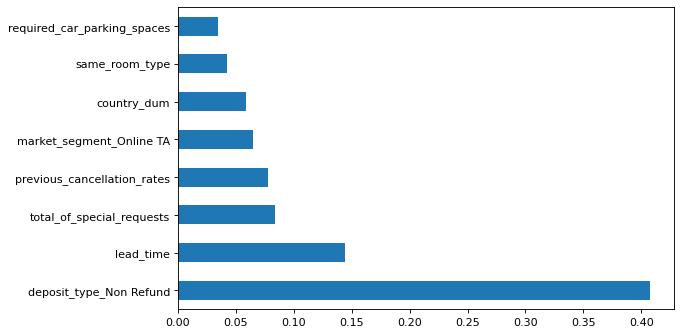

In [41]:
feat_importances = pd.Series(DTC_3.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')

- Moreover, we check the importance of features. The feature importance only indicates a variable's predictive power but does not show whether the effect is positive or negative. We get the sign of the effect on `is_canceled` based on their correlationships, which are described above. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. 

- From the bar chart above, we check the eight most important features. We can observe that `deposit_type_Non Refund` and `lead_time` contribute most to the final decision tree. Intuitively, the more extended customers do not cancel a booking, the less probability it will cancel in the future. It is a counter-intuitive finding that a booking with a non-refundable deposit is more likely to be cancelled. We will explore it deeper later.

- It is also reasonable that bookings with more car parking spaces and other special requests are less likely to be cancelled since when these requirements are satisfied, customers have fewer reasons to cancel bookings. 

- It is also intuitive that when the booked room type matches the actual room type, the booking is less likely to be cancelled.

deposit_type analysis:

From the following table, we can get that non-refundable booking often has a high previous cancellation rate. It means that the group of people who are most likely to cancel the room tend to book rooms with a non-refundable policy, which can explain why a booking with a non-refundable deposit is more likely to be cancelled.

In [42]:
pd.set_option('display.max_columns', None)
X_train.groupby(X_train['deposit_type_Non Refund']).describe(include='all')

total_of_special_requests                      \
                                            count      mean       std   
deposit_type_Non Refund                                                 
0                                         69714.0  0.092871  1.027764   
1                                          8916.0 -0.719393  0.062820   

                                                                           \
                              min       25%       50%       75%       max   
deposit_type_Non Refund                                                     
0                       -0.721948 -0.721948 -0.721948  0.543689  5.606235   
1                       -0.721948 -0.721948 -0.721948 -0.721948  1.809325   

                        required_car_parking_spaces                      \
                                              count      mean       std   
deposit_type_Non Refund                                                   
0                                           69714.0  0.029540  1.051073   
1                                            8916.0 -0.251474  0.043613   

                                                                            \
                              min       25%       50%       75%        max   
deposit_type_Non Refund                                                      
0                       -0.251936 -0.251936 -0.251936 -0.251936  32.693044   
1                       -0.251936 -0.251936 -0.251936 -0.251936   3.866186   

                        booking_changes                                        \
                                  count      mean       std      min      25%   
deposit_type_Non Refund                                                         
0                               69714.0  0.041037  1.061919 -0.34109 -0.34109   
1                                8916.0 -0.320294  0.208145 -0.34109 -0.34109   

                                                     lead_time            \
                             50%      75%        max     count      mean   
deposit_type_Non Refund                                                    
0                       -0.34109 -0.34109  27.942075   69714.0 -0.117128   
1                       -0.34109 -0.34109   5.944058    8916.0  0.892716   

                                                                           \
                              std       min       25%       50%       75%   
deposit_type_Non Refund                                                     
0                        0.925202 -1.030832 -0.880424 -0.439943  0.419533   
1                        1.087881 -1.030832 -0.042435  0.752579  1.923614   

                                  previous_cancellation_rates            \
                              max                       count      mean   
deposit_type_Non Refund                                                   
0                        2.976472                     69714.0 -0.130697   
1                        2.976472                      8916.0  1.004900   

                                                                           \
                              std       min       25%       50%       75%   
deposit_type_Non Refund                                                     
0                        0.667736 -0.234785 -0.234785 -0.234785 -0.234785   
1                        2.031193 -0.234785 -0.234785 -0.234785  4.332584   

                                  same_room_type                           \
                              max          count      mean       std  min   
deposit_type_Non Refund                                                     
0                        4.332584        69714.0  0.854764  0.352341  0.0   
1                        4.332584         8916.0  0.994729  0.072417  0.0   

                                               hotel                           \
                         25%  50%  75%  max    count      mean       std  min   
deposit_type_Non Refun

To summarize our final decision tree model, base on the test dataset, 83.92% of the bookings are truely classifiedthe. The model can successfuly classify 90.96% of non-canceled bookings and 71.48% of canceled bookings. When a booking is predicted as cancelled, it is correct 81.74% of the time. When a booking is predicted as non-cancelled, it is correct 84.93% of the time.

## 4. Discussion & Conclusions


We used the decision trees as our final predicting model as it is the model with highest accuracy. The intuition for our choice is that a company can get more profits by taking advantage of a model with a higher accuracy.

However, even though the accuracy of our model is 83.92% which is relatively high, it still can not guarantee a correct prediction. In addition, there is a 81.74% precision for our model, which means there will be 81.74% correct predictions for the bookings cancelled. In other words, for those bookings which the model predicts to be cancelled, 18.26% bookings won't be cancelled eventually. If we just follow the model predictions, then some rooms will be double booked. What's more, there is a possibility of 15.07% such that the bookings won't be cancelled in our predictions cancelled by customers. This will lead to loss of some customers when there are potential empty rooms available. According to the statistics we got, we found the second situation is more probable. That means, in some extent, the hotels are allowed to have some overbookings because there will be more unexpected cancellations than unexpected keeping of the reservations. However, for the purpose of retaining good reputation, we think hotels should not be even more aggressive than the model predictions.

From our final decision tree model, indicators, such as `deposity_type`, `lead_time`, `total_of_special_requests`, `previous_cancellation_rates`, `same_room_type`, and `required_car_parking_spaces` have relatively large
importance on the cancellation decisions of customers.These findings not only help hotels to predict whether a booking will be canceled in the future, and hence leave that room available to other customers to make more gains, 
but also give suggestions to hotels on their daily hotel operations.
- A non-refundable booking is less likely to be canceled. It is counter-intuitive and maybe because that customers who like to cancel tend to book non-refundable rooms.
- A larger `lead_time` indicates that the booking is less likely to be canceled. It is intuitive and very easy to understand. Hotels should pay much attension to the number of days that elapsed between the entering date of the booking into the PMS and the arrival date, which is helpful for hotels to predict which rooms are more likely to be canceled.
- A booking with more car parking spaces and other special requests is less likely to be canceled. Hotels should satisfy customers' requests as many as possible, since when those requirements are meet, those customers will have fewer reasons to cancel their bookings.
- `previous_cancellation_rates` is a useful indicator for hotels to indentify whether a booking will be canceled. Hotels could separate those bookings out and do extra management.
- Hotels could do extra work on maximizing the matching between the type of room assigned to the booking and room type reserved, which might help to reduce the cancellation probability of a booking.